<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# <font color="#76b900"> **Notebook 8:** Course Assessment

**Congratulations On (Almost) Finishing The Course!** 

We hope you've enjoyed the journey and have gained valuable skills to get starting with building novel and interesting language-guided applications. Now, it's time to put those skills to the test for an assessment!

In previous sections, we've explored various aspects of language models, including data pipelining tools, visual language models (VLMs), and diffusion models. In this assessment, we'll bring all these concepts together to build an interesting application that you likely take for granted if you've ever used an image generator.

### **Setup**

Before we begin, let's set up our environment by importing the necessary libraries and initializing our language model.

In [1]:
import requests
from langchain_nvidia_ai_endpoints import ChatNVIDIA

## USE THIS ONE TO START OUT WITH. NOTE IT'S INTENTED USE AS A VISUAL LANGUAGE MODEL FIRST
# model_path="http://localhost:9000/v1"
## USE THIS ONE FOR GENERAL USE AS A SMALL-BUT-PURPOSE CHAT MODEL BEING RAN LOCALLY VIA NIM
model_path="http://nim:8000/v1"
# ## USE THIS ONE FOR ACCESS TO CATALOG OF RUNNING NIM MODELS IN `build.nvidia.com`
# model_path="http://llm_client:9000/v1"

model_name = requests.get(f"{model_path}/models").json().get("data", [{}])[0].get("id")
%env NVIDIA_BASE_URL=$model_path
%env NVIDIA_DEFAULT_MODE=open

if "llm_client" in model_path:
    model_name = "meta/llama-3.1-70b-instruct"

llm = ChatNVIDIA(model=model_name, base_url=model_path, max_tokens=5000, temperature=0)

env: NVIDIA_BASE_URL=http://nim:8000/v1
env: NVIDIA_DEFAULT_MODE=open


<hr>
<br>

## **Part 8.1:** Assessment

For the course assessment, you will be implementing a common feature that usually sits behind the API of an image-generating endpoint; **synthetic prompts**.

When creating text-conditioned diffusion models, developers usually create synthetic keyword-rich datasets for training that allow the model to learn strong customization priors. 
- **In an ideal scenario,** an image generator could be prompted to generate a truly-arbitrary high-quality image that perfectly fits any natural-language prompt - as long as the prompt itself is expressive enough.
- **In practice,** image generators are prompted - and sometimes trained - with loose directives and the model makes sprawling assumptions about the details based on its training data. This commonly manifests as "image retrieval," where training data with only minor modifications gets produced.

Most providers would be more interested in giving people the freedom to prompt the model however they want, so many choose to incorporate text-to-text interfaces that map from "regular human prompt" to "diffusion input prompt" space. 

### **Exercise:** Image-Inspired Generation

For the course exercise, you will implement a potential schema that combines synthetic prompts with vision to "create images inspired by another image." The process is broken down into tasks below, and will need to be incorporated at the end to pass the assessment. 

<div><img src="imgs/rad-assessment.png" width="800"/></div>

**NOTE:** Tasks 1 through 3 are merely building blocks to implement the final solution in Task 4. Only the results of Task 4 will be graded. Feel free to skip tasks 1 through 3 if you are confident that it will not necessary.

<hr>
<br>

### **[Task 1]** Image Ingestion

First off, we need to be able to take in and reason about an image. To do this, implement the `ask_about_image` method below:

**Simplifying Assumptions:**
- It shouldn't be too hard to have your LLM predict both a question and an image file, but feel free to hardcode the question instead.
- It's generally best to leverage some combination of batching, caching, grouping, and preprocessing depending on how frequently your image pool gets updated. Feel free to forego such optimizations.
- LangChain connectors like `ChatNVIDIA` and `ChatOpenAI` do actually provide a streamlined interface, but feel free to recycle the requests code from before. Whatever's easiest.

**HINTS:**
- Recall your learnings from the VLM spinup in notebook 6. Perhaps we could use that model? Is it still up?
- More of a note, but some models like GPT-4o are extremely strong as both chat and image-reasoning models. 

In [28]:
import requests
import base64

def ask_about_image(image_path, question):
    
    invoke_url = "http://localhost:9000/v1/chat/completions"
    
    with open(image_path, "rb") as f:
        image_b64 = base64.b64encode(f.read()).decode()

    headers = {
        "Authorization": "Bearer $API_KEY_REQUIRED_IF_EXECUTING_OUTSIDE_NGC",
        "Accept": "application/json"
    }

    payload = {
        "model": "microsoft/phi-3.5-vision-instruct",
        "messages": [
            {"role": "system", "content": question},
            {"role": "user", "content": [
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_b64}", "detail": "high"}}
            ]}
        ],
        "max_tokens": 77,
        "temperature": 0.2,
        "top_p": 0.7,
        "stream": False
    }

    try:
        response = requests.post(invoke_url, headers=headers, json=payload)
        response.raise_for_status()
        data = response.json()
        return data.get("choices", [{}])[0].get("message", {}).get("content", "No description available")
    except requests.exceptions.RequestException as e:
        return f"Error: {str(e)}"

description_prompt = "Describe the image"

description = ask_about_image("img-files/paint-cat.jpg", description_prompt)

print(description)


 The image shows a close-up of a cat's face. The cat has a mix of fur colors, predominantly grey with some orange and black patches. It has striking yellow eyes and a pink nose. The cat's ears are pointed and have a tuft of fur at the tips. The background is a blurred mix of pink and blue


<hr>
<br>

### **[Task 2]** Image Creation

Now that we have our image descriptions, let's try to generate an image based on this response:

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

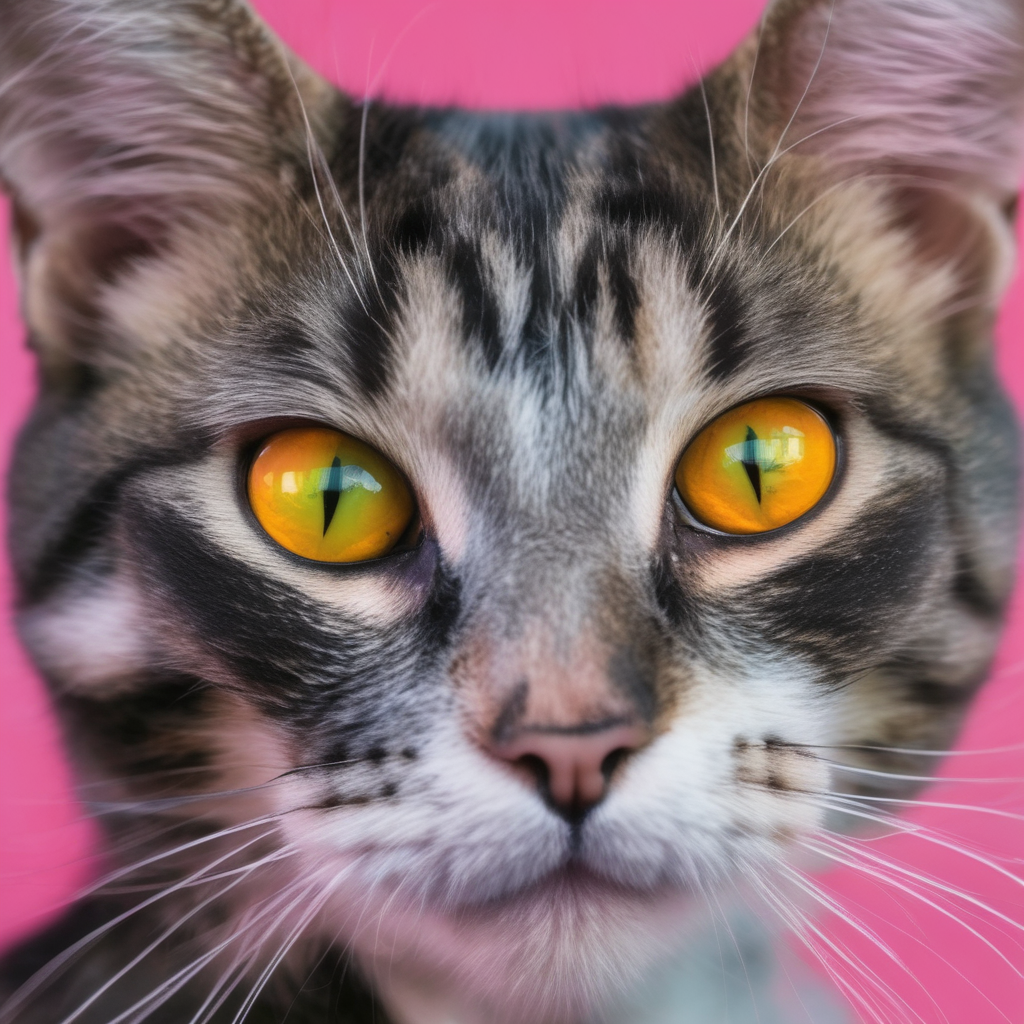

In [29]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
).to("cuda")

def generate_image(prompt):
    
    if not prompt:
        raise ValueError("Prompt cannot be empty")

    images = pipe(prompt=prompt).images
    return images 

images = generate_image(description)
for img in images:
    img.show()


<hr>
<br>

### **[Task 3]** Prompt Synthesis

After an initial attempt, you should notice that this type of description is far too complex. Perhaps we can get better results if we connect these two disparate components with an LLM-enabled interface?

In the abstract, this interface is helping to map from the VLM output domain to the Diffusion input domain, but could have been done between just about any two function specifications. **In more simple terms, we're trying to map from VLM description to Diffusion prompt using an intermediate step.**

Refined Prompt: Human: Based on the image description, generate a concise and clear diffusion prompt. Description: The image shows a close-up of a cat's face. The cat has a mix of fur colors, predominantly grey with some orange and black patches. It has striking yellow eyes and a pink nose. The cat's


  0%|          | 0/50 [00:00<?, ?it/s]

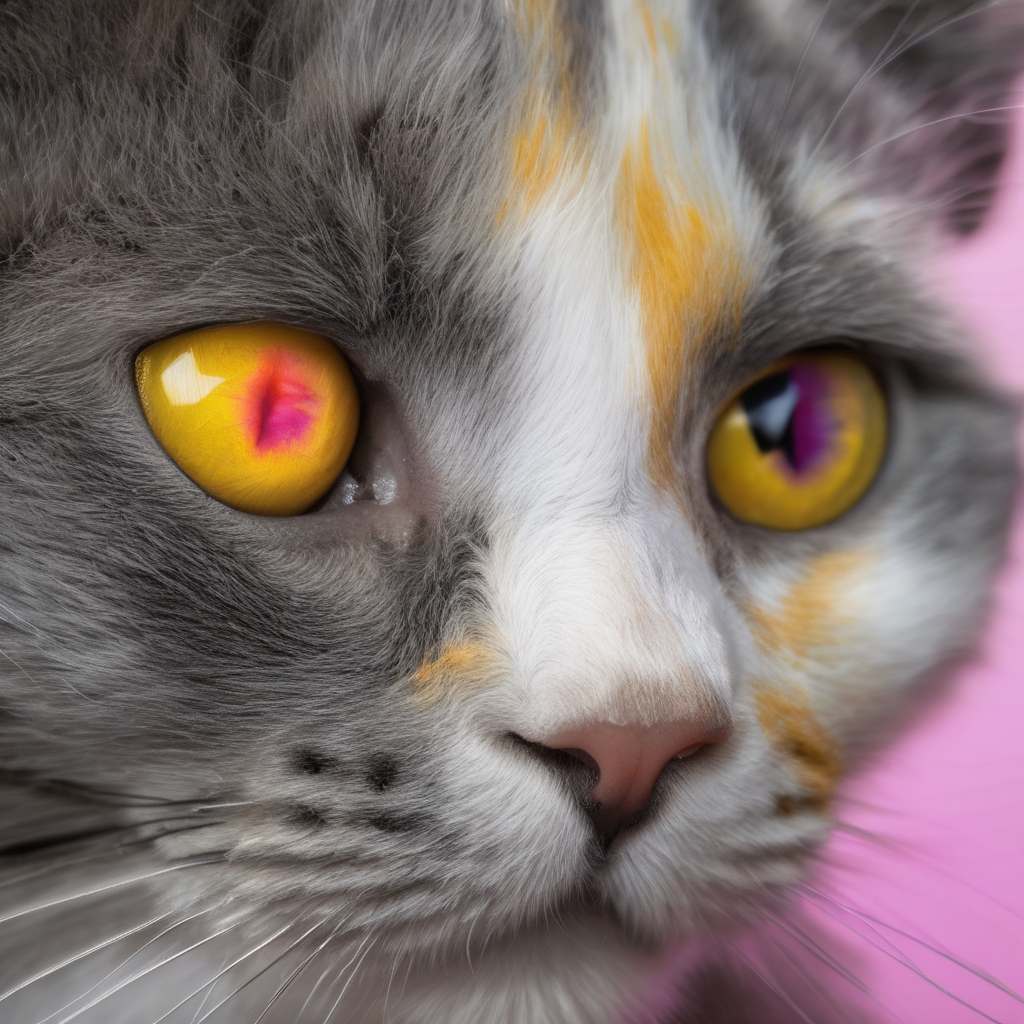

In [32]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

template = """
Based on the image description, generate a concise and clear diffusion prompt.
Description: {description}
Output: 
"""

def refine_prompt(description):
    prompt_template = ChatPromptTemplate.from_template(template)
    refined_prompt = prompt_template.format(description=description)
    
    tokenized_prompt = refined_prompt.split()
    if len(tokenized_prompt) > 50:
        refined_prompt = ' '.join(tokenized_prompt[:50])
    
    return refined_prompt

description_prompt = "Describe the image"
description = ask_about_image("img-files/paint-cat.jpg", description_prompt)
refined_prompt = refine_prompt(description)

print("Refined Prompt:", refined_prompt)

images = generate_image(refined_prompt)
for img in images:
    img.show()


<hr>
<br>

### **[Task 4]** Pipelining and Iterating

**To finish the assessment, incorporate these tasks into a pipeline to make the following process turn-key:**
- **Take in an image from the compute environment.**
- **Compute a summary of the image.**
- **Use an LLM to create four different synthetic prompts for the image generation pipeline.**
- **Produce four destinct images that you are happy with.**

**NOTES:**
- Feel free to implement it as either a standard function or a chain.
- Return an array of PIL Images. You can optionally display them by default.
- To speed up the process, we recommend trying out parallel processes and batching. 

In [33]:
def generate_images_from_image(image_url: str, num_images = 4):
    description_prompt = "Describe the image"
    original_description = ask_about_image("imgs/agent-overview.png", description_prompt)

    diffusion_prompts = []
    for i in range(num_images):
        diffusion_prompts.append(refine_prompt(original_description))

    generated_images = []
    for i in range(num_images):
        generated_images.extend(generate_image(diffusion_prompts[i]))

    return generated_images, diffusion_prompts, original_description

results = []
results += [generate_images_from_image("imgs/agent-overview.png")]
results += [generate_images_from_image("imgs/multimodal.png")]
results += [generate_images_from_image("img-files/tree-frog.jpg")]
results += [generate_images_from_image("img-files/paint-cat.jpg")]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

<hr>
<br>

## **Part 8.2:** Running The Assessment

To assess your submission, run the following cells to save your results and the one after to query the assessment runner.

**Follow the instructions and make sure it all passes.**

In [27]:
import os
import json
import requests
from PIL import Image
import re

def save_images_and_metadata(results, save_dir="generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    
    # Collect all image paths and metadata
    all_metadata = []
    taken_idxs = [re.findall(r'\d+', filename) for filename in os.listdir(save_dir)]
    taken_idxs = [int(idx_list[0]) for idx_list in taken_idxs if idx_list]
    start_idx = max(taken_idxs, default=0) + 1  # Find the next available index

    for result in results:
        images, prompts, original_description = result
        img_paths = []

        # Save each image and store its path
        for idx, img in enumerate(images):
            img_path = os.path.join(save_dir, f"image_{start_idx + idx}.png")
            img.save(img_path, "PNG")
            img_paths.append(img_path)
        
        # Append metadata for the current batch
        all_metadata.append({
            "original_description": original_description,
            "prompts": prompts,
            "image_paths": img_paths
        })
        start_idx += len(images)
    
    # Save all metadata in a single JSON file
    metadata_path = os.path.join(save_dir, "all_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(all_metadata, f, indent=4)
    return all_metadata

## Generate your submission
submission = save_images_and_metadata(results)

## Send the submission over to the assessment runner
response = requests.post(
    "http://docker_router:8070/run_assessment", 
    json={"submission": submission},
)

response.raise_for_status()

try: 
    print(response.json().get("result"))
    if response.json().get("messages"):
        print("MESSAGES:", "\n- ".join([""] + response.json().get("messages")))
    if response.json().get("exceptions"):
        print("EXCEPTIONS:", "\n- ".join([""] + [str(v) for v in response.json().get("exceptions")]))
except:
    print("Failed To Process Assessment Response")
    print(response.__dict__)

Congratulations! You passed the assessment!
See instructions below to generate a certificate.


<br>

If you passed the assessment, please return to the course page (shown below) and click the **"ASSESS TASK"** button, which will generate your certificate for the course.

<img src="./imgs/assess_task.png" style="width: 800px;">


<hr>
<br>

## **Part 8.3:** Wrapping Up

### <font color="#76b900">**Congratulations On Completing The Course!!**</font>

Before concluding the course, we highly recommend downloading the course material for later reference, and checking over the **"Next Steps"** and **Feedback** sections of the course. **We appreciate you taking the time to go through the course, and look forward to seeing you again for the next courses in the series!**

<br>
<hr>

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>